In [1]:
import sys

# Redirect prints to a file
sys.stdout = open("results/logs.txt", "w")

In [2]:
import torch
import numpy as np
import random

seed = 42

random.seed(seed)

np.random.seed(seed)

torch.manual_seed(seed)

print(f"Set random seed to {seed}")

In [ ]:
from src.utils.config import TRAIN_DATA_POINTS, TEST_DATA_POINTS, N_CLASSES
from src.utils.load_data import load_data
from src.utils.processing import generate_class_matrix, generate_test_class_matrix
from src.utils.augmentation import augment_data

augmentation = True

train_data = None
train_class_matrix = None

if augmentation:
    train_data, train_class_matrix = augment_data(
        load_data("data/ae.train", num_data_points=TRAIN_DATA_POINTS))

else:
    train_data = load_data("data/ae.train", num_data_points=TRAIN_DATA_POINTS)
    train_class_matrix = generate_class_matrix(TRAIN_DATA_POINTS, N_CLASSES)

test_data = load_data("data/ae.test", num_data_points=TEST_DATA_POINTS)
test_class_matrix = generate_test_class_matrix(TEST_DATA_POINTS, N_CLASSES)

TRAIN_DATA_POINTS = train_data.shape[0]

The following code displays a random data point.

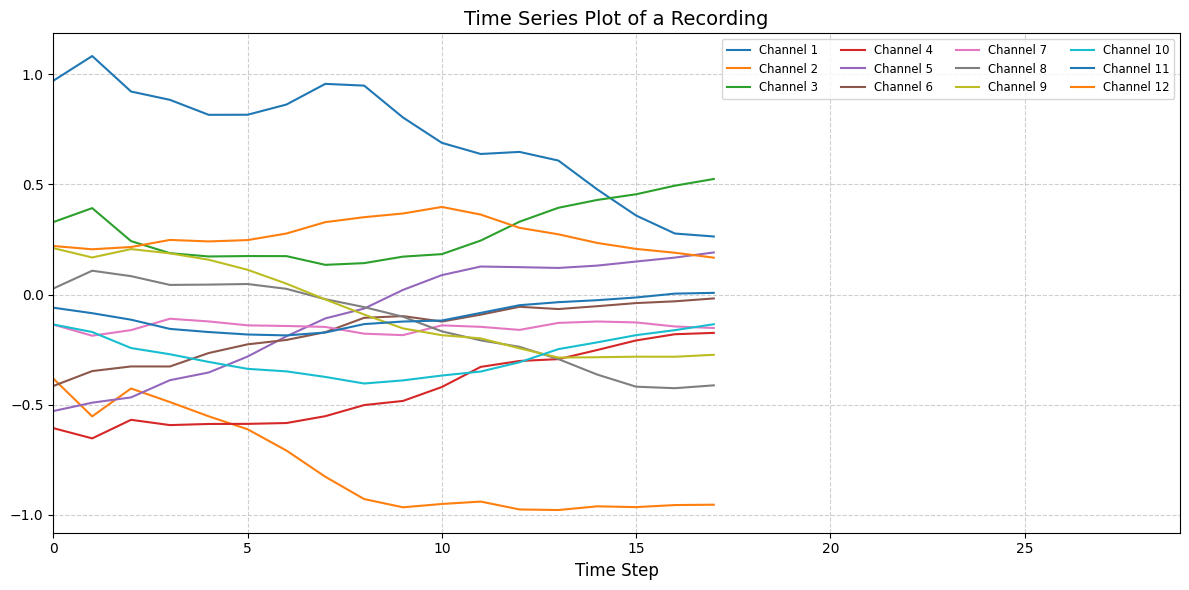

In [4]:
from src.utils.visualize_data import visualize_data_point
import numpy as np

data_idx = np.random.randint(0, TRAIN_DATA_POINTS)

visualize_data_point(train_data[data_idx])

Visualizing the pattern mean of the training data. The tail of the signal is less smooth, because the number of data points that reach that lenght taper off.

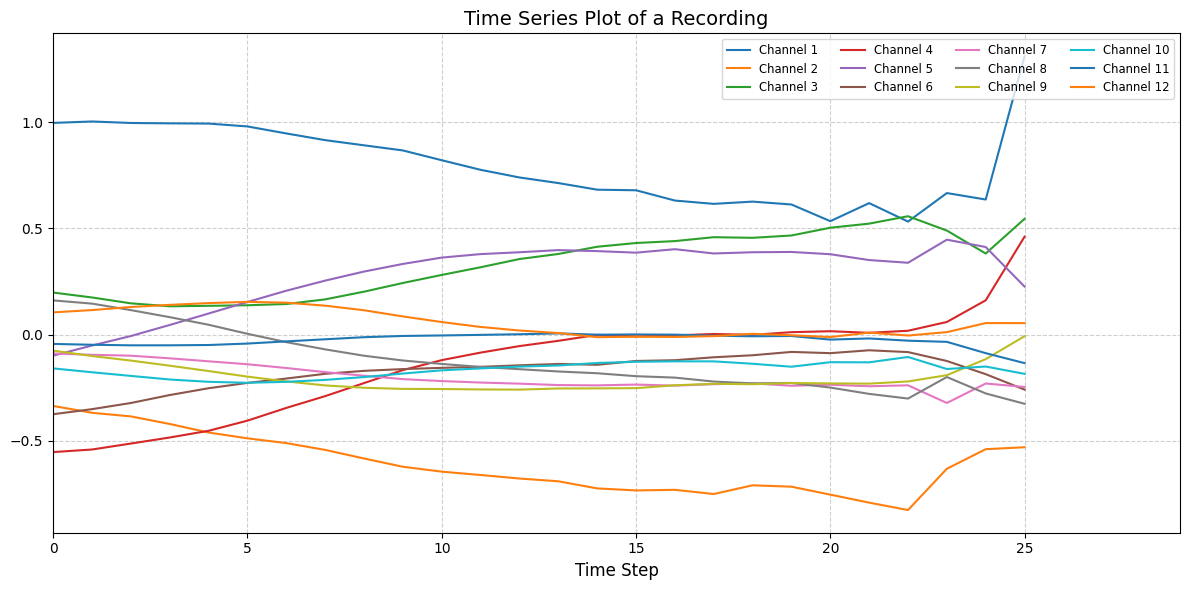

In [5]:
from src.utils.processing import get_pattern_mean

train_pattern_mean = get_pattern_mean(train_data)
visualize_data_point(train_pattern_mean)

The distribution of signal lengths in the training data

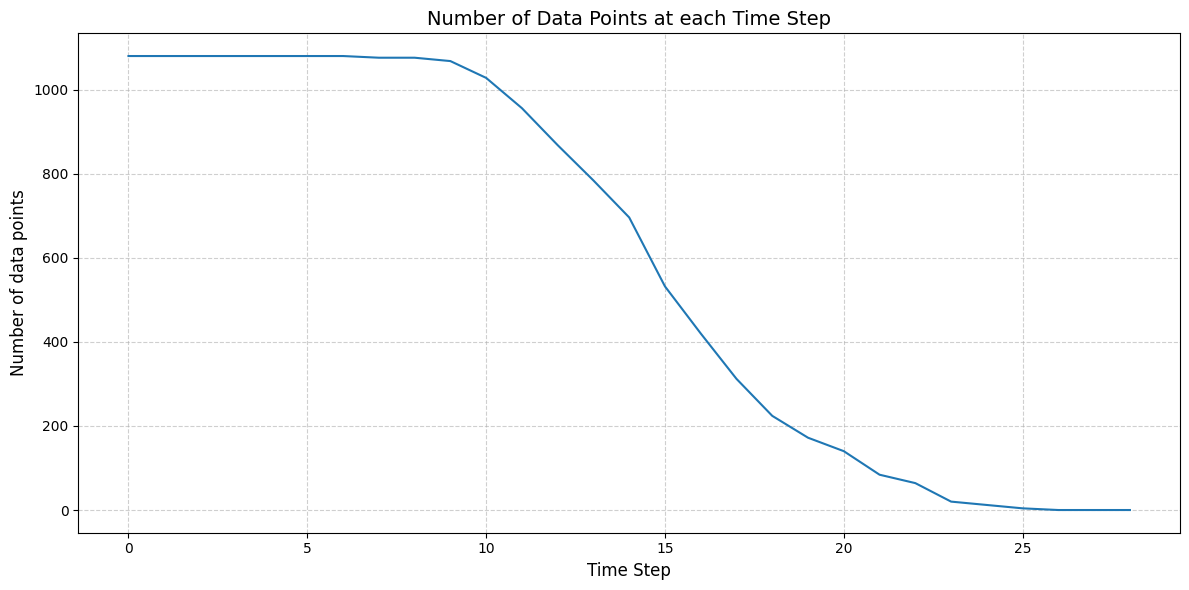

In [6]:
from src.utils.processing import get_time_steps
from src.utils.visualize_data import visualize_data_lengths

time_steps = get_time_steps(train_data)
visualize_data_lengths(time_steps)

Visualizing the pattern means for all classes, to get an insight and feel for the different classes.

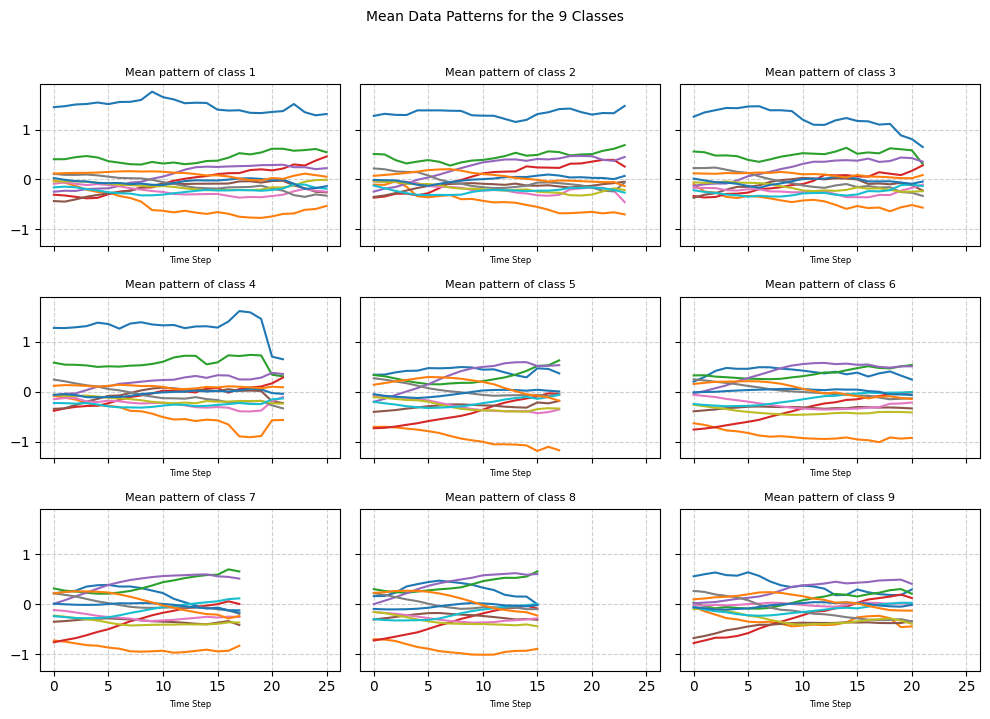

In [7]:
from src.utils.visualize_data import visualize_class_means

visualize_class_means(train_data)

The first step of Principal Component Analysis (PCA) is to obtain the Principal Components (PCs) and the respective feature variances.

In [8]:
from src.utils.pca import normalize, SVD, reduce_PCs, get_feature_vectors

train_data = normalize(train_data, train_pattern_mean)
test_data = normalize(test_data, train_pattern_mean)

principal_components, feature_variances = SVD(train_data)
reduced_PCs = reduce_PCs(feature_variances, principal_components, wanted_variance=99)

train_feature_vectors = get_feature_vectors(train_data, reduced_PCs)
test_feature_vectors = get_feature_vectors(test_data, reduced_PCs)

Here we can see the variance distribution of the PCs. Notice that there are more features than data points. Therefore, the variance after the number of training data points (270) drops to 0.

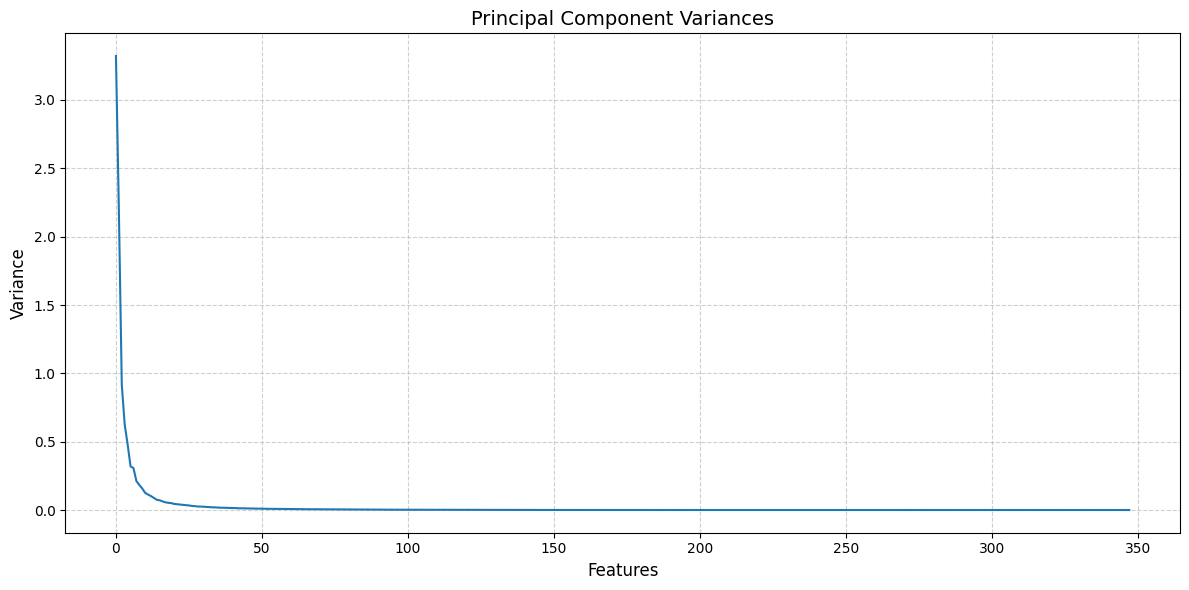

In [9]:
from src.utils.visualize_data import visualize_PC_variance

visualize_PC_variance(feature_variances, log=False)

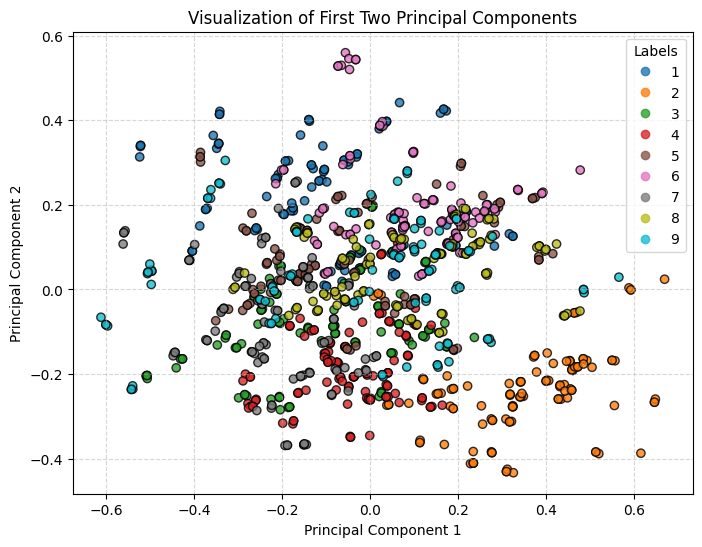

In [10]:
from src.utils.visualize_results import plot_first_2_PCs
train_class_matrix
labels = np.argmax(train_class_matrix, axis=1) + 1
plot_first_2_PCs(train_feature_vectors, labels)

# Now we run k-fold CVs

In [11]:
from src.utils.k_fold import get_k_folds

folds = get_k_folds(train_feature_vectors, train_class_matrix, k=5)
leave_one_out_folds = get_k_folds(train_feature_vectors, train_class_matrix, k=TRAIN_DATA_POINTS)

#### Ridge linear regression performing cross-validation to find best regularization parameter

In [ ]:
from src.linear_regression.classifier import compute_ridge_regression_classifier, compute_MSE, compute_mismatch
from src.utils.visualize_results import show_lambda_search_results

print("\nLinear Regression CV\n")
# candidate λ values to test
lambda_grid = [0.001, 0.01, 0.1, 1.0, 10.0]

best_lambda = None
best_acc = 0

results = {}

for lambda_reg in lambda_grid:
    accuracies = []

    for x_train, y_train, x_val, y_val in leave_one_out_folds:
        W = compute_ridge_regression_classifier(x_train, y_train, lambda_reg)
        mismatch = compute_mismatch(W, x_val, y_val)
        val_acc = 1 - mismatch 
        accuracies.append(val_acc)

    mean_acc = np.mean(accuracies)
    results[lambda_reg] = mean_acc

    if mean_acc > best_acc:
        best_acc = mean_acc
        best_lambda = lambda_reg

print("Best lambda:", best_lambda)
print("Best Mean Validation Accuracy:", best_acc)

ridge_reg = compute_ridge_regression_classifier(train_feature_vectors, train_class_matrix, lambda_reg=best_lambda)
mse_ridge = compute_MSE(ridge_reg, test_feature_vectors, test_class_matrix)
mismatch_ridge = compute_mismatch(ridge_reg, test_feature_vectors, test_class_matrix)

print("Ridge Test MSE: ", mse_ridge)
print("Ridge Test Mismatch: ", mismatch_ridge)

ridge_reg_accuracy = 1 - mismatch_ridge
print("Ridge Reg Accuracy: ", ridge_reg_accuracy)

show_lambda_search_results(results, "results/hyperparameter_ridge.png")

# TREE

In [ ]:
from src.random_forest.evaluate import train_and_evaluate_random_forest, prepare_tensors_for_training 
import itertools

print("\nRandom Forest CV\n")

n_trees_options = [50, 100, 150, 200]
max_depth_options = [5, 10, 15, 20]

hyperparam_grid = list(itertools.product(n_trees_options, max_depth_options))

best_acc = 0
best_params = None

results = {}

for params in hyperparam_grid:
    n_trees, max_depth = params

    fold_metrics = []
    accuracies = []

    for x_train, y_train, x_val, y_val in folds:
        X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor = prepare_tensors_for_training(
            x_train, y_train, x_val, y_val
        )

        model, val_accuracy, _ = train_and_evaluate_random_forest(
            X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor,
            n_trees=n_trees,
            max_depth=max_depth
        )

        print("n_trees: {}, max_depth: {}".format(n_trees, max_depth))
        print(f"Validation accuracy: {val_accuracy}\n")

        accuracies.append(val_accuracy)
    
    mean_acc = np.array(accuracies).mean()
    results[(n_trees, max_depth)] = mean_acc

    if mean_acc > best_acc:
        best_acc = mean_acc
        best_params = params

print("Best n_trees: {}, best max_depth: {} ".format(*best_params))
print("Best Mean Accuracy: ", best_acc)

X_train, y_train, X_test, y_test = prepare_tensors_for_training(
    train_feature_vectors, train_class_matrix,
    test_feature_vectors, test_class_matrix
)

rf_model, test_acc, forest_metrics = train_and_evaluate_random_forest(
    X_train, y_train, X_test, y_test, best_params[0], best_params[1]
)

print("Test Accuracy: ", test_acc)
print("Test Metrics:")
for metric, val in forest_metrics.items():
    print(f"{metric}: {val}")

Plot CV search heatmap:

In [ ]:
from src.utils.visualize_results import plot_cv_heatmap
plot_cv_heatmap(results, n_trees_options, max_depth_options)

# K-NN approach

The following block of code is run to perform a hyperparameter search on the number of nearest neighbors.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


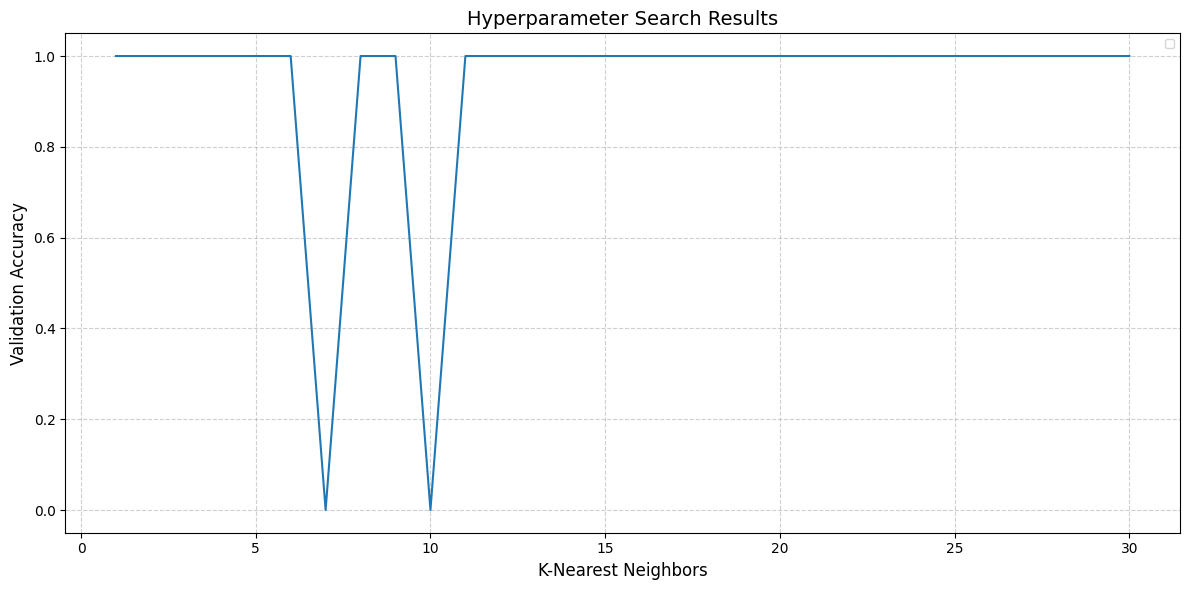

In [14]:
from src.knn.knn_pipeline import knn_hyperparameter_search, get_knn_predictions
from src.utils.metrics import compute_accuracy
from src.utils.visualize_data import show_search_results

print("\nKNN CV\n")

k_to_search = range(1, 11)

# leave-one-out cross validation
results = knn_hyperparameter_search(
    data=train_data, 
    labels=train_class_matrix, 
    k_to_search=k_to_search, 
    k_folds=TRAIN_DATA_POINTS
)

print('CV results:', results)

show_search_results(results, "results/hyperparameter_knn.png")
best_k = max(results, key=results.get)
print(f"Best k found:{best_k}; with accuracy: {results[best_k]}")

# the number of nearest neighbors with the highest validation accuracy
predictions = get_knn_predictions(best_k, test_data, train_data, train_class_matrix)
accuracy = compute_accuracy(predictions, np.argmax(test_class_matrix, axis=1))

print("Accuracy:\t{:.3f}%".format(accuracy))

# Results

### Ridge Regression

In [ ]:
import torch
import numpy as np
from src.random_forest.evaluate import compute_per_class_metrics
from src.utils.visualize_results import plot_cm

# Get predictions and true labels
Y_pred = np.matmul(test_feature_vectors, ridge_reg)
Y_true = np.argmax(test_class_matrix, axis=1)  
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Compute per-class metrics
ridge_reg_metrics = compute_per_class_metrics(torch.from_numpy(Y_pred_classes), torch.from_numpy(Y_true), num_classes=test_class_matrix.shape[1])
print(f"Ridge Regression Metrics: {ridge_reg_metrics}")

plot_cm("Confusion Matrix (Ridge Linear Regression)", Y_true, Y_pred_classes, "results/rlr_cm.png")

NameError: name 'ridge_reg' is not defined

### K-NN

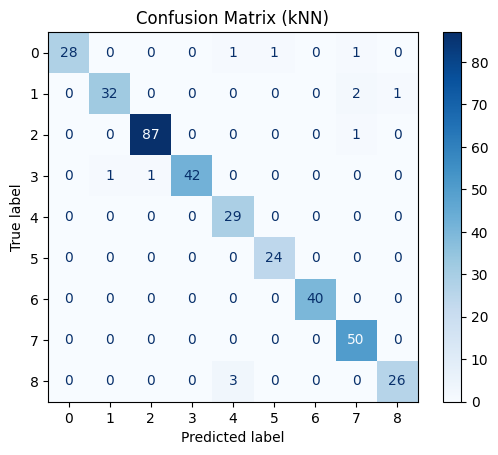

In [ ]:
from src.knn.knn_pipeline import get_distances, predict
from src.random_forest.evaluate import compute_per_class_metrics
from src.utils.visualize_results import plot_cm
import torch

best_k = 1

Y_true = np.argmax(test_class_matrix, axis=1) 
Y_pred_classes = []

for data_point in test_data:
    distances = get_distances(data_point, train_data)
    pred_class = predict(best_k, distances, train_class_matrix)
    Y_pred_classes.append(pred_class)

Y_pred_classes = np.array(Y_pred_classes)

knn_metrics = compute_per_class_metrics(
    torch.from_numpy(Y_pred_classes),
    torch.from_numpy(Y_true),
    num_classes=test_class_matrix.shape[1]
)

print(f"KNN Metrics: {knn_metrics}")

plot_cm("Confusion Matrix (kNN)", Y_true, Y_pred_classes, "results/knn_cm.png")

### Random Forest

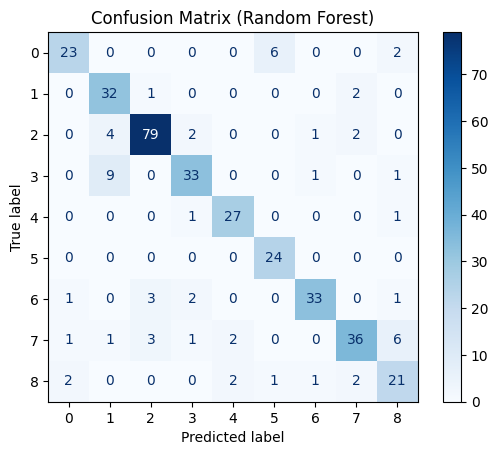

In [ ]:
import torch
import numpy as np
from src.random_forest.evaluate import compute_per_class_metrics
from src.utils.visualize_results import plot_cm

torch.from_numpy(test_feature_vectors)

# Get predictions and true labels
with torch.no_grad():
    Y_pred_classes = rf_model(test_feature_vectors)

Y_true = np.argmax(test_class_matrix, axis=1)

# Compute per-class metrics
random_forest_metrics = compute_per_class_metrics(Y_pred_classes, torch.from_numpy(Y_true), num_classes=test_class_matrix.shape[1])
print(f"Random Forest Metrics: {random_forest_metrics}")

plot_cm("Confusion Matrix (Random Forest)", Y_true, Y_pred_classes, "results/rf_cm.png")

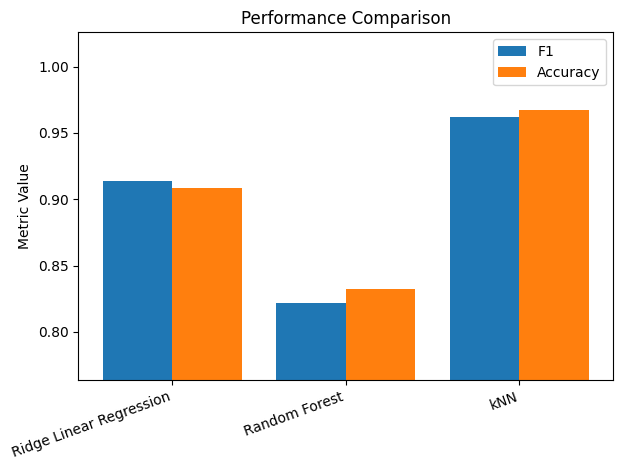

In [ ]:
from src.utils.visualize_results import plot_metrics

results = {
    'Ridge Linear Regression': {'F1': ridge_reg_metrics['overall']['f1'], 'Accuracy': ridge_reg_metrics['overall']['accuracy']},
    'Random Forest': {'F1': forest_metrics['overall']['f1'], 'Accuracy': forest_metrics['overall']['accuracy']},
    'kNN': {'F1': knn_metrics['overall']['f1'], 'Accuracy': knn_metrics['overall']['accuracy']}
}

plot_metrics(results)



In [14]:
sys.stdout.close()
sys.stdout = sys.__stdout__ # Restore printing